# Getting started with MLflow
Emanuel Tomé\
May 2024

## 1. Load packages

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

In [2]:
import mlflow

In [3]:
mlflow.set_tracking_uri("sqlite:///../mlflow/mlflow.db")
# mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("nyc-taxi-experiment")

2024/05/26 13:38:24 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/erstome/MLOps-zoomcamp-2024/02-experiment-tracking/mlruns/1', creation_time=1716727104257, experiment_id='1', last_update_time=1716727104257, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

## 2. Q1 - Downloading the data

In [4]:
def read_data(filename: str) -> pd.DataFrame:
    "Function to read parquet file"
    return pd.read_parquet(filename)

january_data = read_data('../data/green_tripdata_2023-01.parquet')
february_data = read_data('../data/green_tripdata_2023-02.parquet')


In [5]:
january_data.shape

(68211, 20)

In [6]:
january_data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00


## 3. Q2 - Computing duration

In [7]:
def compute_duration(dataframe: pd.DataFrame) -> pd.DataFrame:
    "Function to compute duration"
    dataframe['duration'] = (
        dataframe['lpep_dropoff_datetime'] - dataframe['lpep_pickup_datetime']
        ).dt.total_seconds()/60
    return dataframe

january_data = compute_duration(january_data)
february_data = compute_duration(february_data)

In [8]:
january_data['duration'].std()

74.92563122537358

In [9]:
january_data['duration'].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

count    68211.000000
mean        18.097271
std         74.925631
min          0.000000
1%           0.083333
5%           3.000000
50%         11.400000
95%         33.266667
99%         58.115000
max       1439.883333
Name: duration, dtype: float64

## 4. Q3 - Dropping outliers

In [10]:
def drop_outliers(dataframe: pd.DataFrame) -> pd.DataFrame:
    "Function to drop outliers"
    return dataframe[(dataframe['duration'] >= 1) & (dataframe['duration'] <= 60)]

In [11]:
january_data_without_outliers = drop_outliers(january_data)
february_data_without_outliers = drop_outliers(february_data)

In [12]:
january_data_without_outliers.shape[0] / january_data.shape[0] * 100


96.6794212077231

In [13]:
february_data_without_outliers.shape[0] / february_data.shape[0] * 100

96.55140489746795

In [14]:
# from sklearn.model_selection import train_test_split

# # Assuming 'column_name' is the column you want to stratify by
# _, january_data_without_outliers = train_test_split(january_data_without_outliers,
#                                                     test_size=0.2,
#                                                     stratify=january_data_without_outliers['duration'],
#                                                     random_state=42)
# _, february_data_without_outliers = train_test_split(february_data_without_outliers,
#                                                      test_size=0.2,
#                                                      stratify=february_data_without_outliers['duration'],
#                                                      random_state=42)

## 5. Q4 - One-hot encoding

In [15]:
def cast_metrics(dataframe: pd.DataFrame) -> pd.DataFrame:
    "Function to cast metrics"
    categorical = ['PULocationID', 'DOLocationID']
    dataframe[categorical] = dataframe[categorical].astype('str')
    return dataframe

In [16]:
january_data_without_outliers = cast_metrics(january_data_without_outliers)
february_data_without_outliers = cast_metrics(february_data_without_outliers)

/tmp/ipykernel_4026/3720923630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[categorical] = dataframe[categorical].astype('str')
/tmp/ipykernel_4026/3720923630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[categorical] = dataframe[categorical].astype('str')


In [17]:
def select_metrics(dataframe: pd.DataFrame) -> pd.DataFrame:
    "Function to select metrics"
    # Definition of metrics
    categorical = ['PULocationID', 'DOLocationID'] #['PU_DO',]
    numerical = ['trip_distance',]
    
    # Join metrics
    dataframe['PU_DO'] = dataframe['PULocationID'] + '_' + dataframe['DOLocationID']
    
    # Select variables
    filtered_df = dataframe[numerical + categorical].copy()
    
    return filtered_df

In [18]:
train_df = select_metrics(january_data_without_outliers)
test_df = select_metrics(february_data_without_outliers)


/tmp/ipykernel_4026/470491184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['PU_DO'] = dataframe['PULocationID'] + '_' + dataframe['DOLocationID']
/tmp/ipykernel_4026/470491184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['PU_DO'] = dataframe['PULocationID'] + '_' + dataframe['DOLocationID']


In [19]:
# Apply one hot encoding
vec = DictVectorizer()
train_dicts = train_df.to_dict(orient='records')
test_dicts = test_df.to_dict(orient='records')

X_train = vec.fit_transform(train_dicts).toarray()


In [20]:

X_test = vec.transform(test_dicts).toarray()

In [21]:
X_train.shape

(65946, 468)

In [22]:
y_train = january_data_without_outliers['duration']
y_test = february_data_without_outliers['duration']

## 6. Q5 - Training a model

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [24]:
y_pred = lr.predict(X_train)

In [25]:
# Save the model
with open('../models/lin_reg_green.bin', 'wb') as f:
    pickle.dump((vec, lr), f)

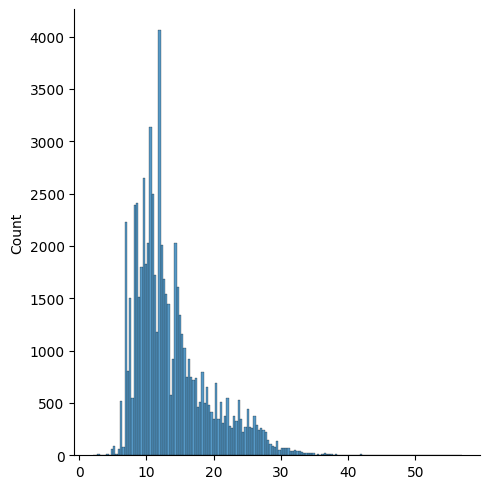

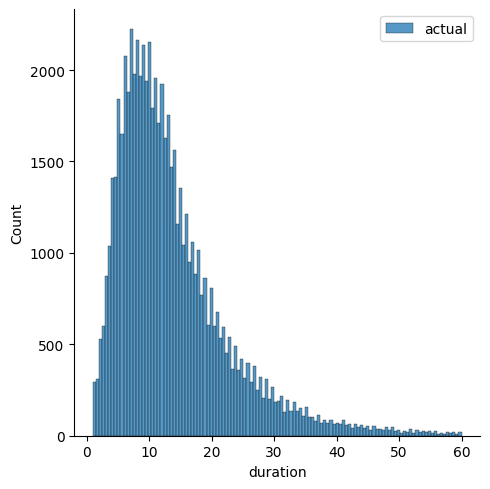

In [26]:
sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

In [27]:
y_pred[y_pred < 1] = 1
y_pred[y_pred > 60] = 60

In [28]:
root_mean_squared_error(y_train, y_pred)

7.039887646604602

In [53]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "Emanuel Tomé")
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2023-01.parquet")
    mlflow.log_param("test-data-path", "./data/green_tripdata_2023-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    # Lasso
    lasso = Lasso(alpha)
    lasso.fit(X_train, y_train)

    y_pred_lasso = lasso.predict(X_train)

    rmse = root_mean_squared_error(y_train, y_pred_lasso)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="../models/lin_reg_green.bin",
                        artifact_path="models_pickle")

## 7. Q6 - Evaluating the model

In [30]:
y_test_pred = lr.predict(X_test)

In [31]:
y_test_pred[y_test_pred < 1] = 1
y_test_pred[y_test_pred > 60] = 60

In [32]:
root_mean_squared_error(y_test.values, y_test_pred)

7.394465618971251

---
## 8. hyperopt

In [35]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [36]:
train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)


In [37]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(test, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(test)
        rmse = root_mean_squared_error(y_test, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [38]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:53:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.38839                           
[1]	validation-rmse:6.29421                           
[2]	validation-rmse:5.70784                           
[3]	validation-rmse:5.41057                           
[4]	validation-rmse:5.27350                           
[5]	validation-rmse:5.20604                           
[6]	validation-rmse:5.17667                           
[7]	validation-rmse:5.16407                           
[8]	validation-rmse:5.16095                           
[9]	validation-rmse:5.15946                           
[10]	validation-rmse:5.16359                          
[11]	validation-rmse:5.16626                          
[12]	validation-rmse:5.16212                          
[13]	validation-rmse:5.16691                          
[14]	validation-rmse:5.16835                          
[15]	validation-rmse:5.17324                          
[16]	validation-rmse:5.17666                          
[17]	validation-rmse:5.17925                          
[18]	valid

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:53:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.86626                                                    
[2]	validation-rmse:5.41222                                                    
[3]	validation-rmse:5.23340                                                    
[4]	validation-rmse:5.16482                                                    
[5]	validation-rmse:5.13383                                                    
[6]	validation-rmse:5.12376                                                    
[7]	validation-rmse:5.12478                                                    
[8]	validation-rmse:5.11594                                                    
[9]	validation-rmse:5.11399                                                    
[10]	validation-rmse:5.10891                                                   
[11]	validation-rmse:5.11092                                                   
[12]	validation-rmse:5.10950                                                   
[13]	validation-rmse:5.11130            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:53:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.02375                                                    
[2]	validation-rmse:5.51898                                                    
[3]	validation-rmse:5.29271                                                    
[4]	validation-rmse:5.19452                                                    
[5]	validation-rmse:5.14018                                                    
[6]	validation-rmse:5.10991                                                    
[7]	validation-rmse:5.09329                                                    
[8]	validation-rmse:5.07865                                                    
[9]	validation-rmse:5.06953                                                    
[10]	validation-rmse:5.06223                                                   
[11]	validation-rmse:5.05761                                                   
[12]	validation-rmse:5.05755                                                   
[13]	validation-rmse:5.05820            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:53:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.21848                                                    
[4]	validation-rmse:5.17858                                                    
[5]	validation-rmse:5.15231                                                    
[6]	validation-rmse:5.13492                                                    
[7]	validation-rmse:5.12775                                                    
[8]	validation-rmse:5.11970                                                    
[9]	validation-rmse:5.11124                                                    
[10]	validation-rmse:5.10138                                                   
[11]	validation-rmse:5.09944                                                   
[12]	validation-rmse:5.10083                                                   
[13]	validation-rmse:5.09858                                                   
[14]	validation-rmse:5.09409                                                   
[15]	validation-rmse:5.09211            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:53:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:5.26545                                                    
[3]	validation-rmse:5.16477                                                    
[4]	validation-rmse:5.12448                                                    
[5]	validation-rmse:5.11276                                                    
[6]	validation-rmse:5.09302                                                    
[7]	validation-rmse:5.07594                                                    
[8]	validation-rmse:5.07426                                                    
[9]	validation-rmse:5.07603                                                    
[10]	validation-rmse:5.06982                                                   
[11]	validation-rmse:5.07273                                                   
[12]	validation-rmse:5.07677                                                   
[13]	validation-rmse:5.07454                                                   
[14]	validation-rmse:5.07020            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:53:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.85211                                                    
[3]	validation-rmse:7.47669                                                    
[4]	validation-rmse:7.14826                                                    
[5]	validation-rmse:6.86416                                                    
[6]	validation-rmse:6.61670                                                    
[7]	validation-rmse:6.40339                                                    
[8]	validation-rmse:6.21810                                                    
[9]	validation-rmse:6.05799                                                    
[10]	validation-rmse:5.92278                                                   
[11]	validation-rmse:5.80622                                                   
[12]	validation-rmse:5.70569                                                   
[13]	validation-rmse:5.62005                                                   
[14]	validation-rmse:5.54712            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:53:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.44141                                                   
[1]	validation-rmse:6.36700                                                   
[2]	validation-rmse:5.77994                                                   
[3]	validation-rmse:5.49531                                                   
[4]	validation-rmse:5.36111                                                   
[5]	validation-rmse:5.29616                                                   
[6]	validation-rmse:5.26865                                                   
[7]	validation-rmse:5.26422                                                   
[8]	validation-rmse:5.27018                                                   
[9]	validation-rmse:5.27757                                                   
[10]	validation-rmse:5.29098                                                  
[11]	validation-rmse:5.29672                                                  
[12]	validation-rmse:5.29951                        

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:53:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.26641                                                   
[3]	validation-rmse:7.96991                                                   
[4]	validation-rmse:7.69814                                                   
[5]	validation-rmse:7.44982                                                   
[6]	validation-rmse:7.22300                                                   
[7]	validation-rmse:7.01525                                                   
[8]	validation-rmse:6.82662                                                   
[9]	validation-rmse:6.65528                                                   
[10]	validation-rmse:6.50038                                                  
[11]	validation-rmse:6.35937                                                  
[12]	validation-rmse:6.23184                                                  
[13]	validation-rmse:6.11757                                                  
[14]	validation-rmse:6.01411                        

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:54:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:5.34721                                                  
[11]	validation-rmse:5.32392                                                  
[12]	validation-rmse:5.31696                                                  
[13]	validation-rmse:5.31114                                                  
[14]	validation-rmse:5.30290                                                  
[15]	validation-rmse:5.29653                                                  
[16]	validation-rmse:5.29349                                                  
[17]	validation-rmse:5.28942                                                  
[18]	validation-rmse:5.28651                                                  
[19]	validation-rmse:5.28502                                                  
[20]	validation-rmse:5.27234                                                  
[21]	validation-rmse:5.27202                                                  
[22]	validation-rmse:5.26195                        

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:54:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:6.66607                                                   
[9]	validation-rmse:6.50750                                                   
[10]	validation-rmse:6.36904                                                  
[11]	validation-rmse:6.24729                                                  
[12]	validation-rmse:6.13936                                                  
[13]	validation-rmse:6.04451                                                  
[14]	validation-rmse:5.96072                                                  
[15]	validation-rmse:5.88635                                                  
[16]	validation-rmse:5.82299                                                  
[17]	validation-rmse:5.76421                                                  
[18]	validation-rmse:5.71395                                                  
[19]	validation-rmse:5.67001                                                  
[20]	validation-rmse:5.63026                        

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:54:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.88855                                                    
[1]	validation-rmse:5.67417                                                    
[2]	validation-rmse:5.69923                                                    
[3]	validation-rmse:5.73608                                                    
[4]	validation-rmse:5.75193                                                    
[5]	validation-rmse:5.75639                                                    
[6]	validation-rmse:5.76209                                                    
[7]	validation-rmse:5.76298                                                    
[8]	validation-rmse:5.76320                                                    
[9]	validation-rmse:5.76554                                                    
[10]	validation-rmse:5.76672                                                   
[11]	validation-rmse:5.76877                                                   
[12]	validation-rmse:5.76959            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:54:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.64266                                                    
[3]	validation-rmse:7.23100                                                    
[4]	validation-rmse:6.88286                                                    
[5]	validation-rmse:6.58802                                                    
[6]	validation-rmse:6.33677                                                    
[7]	validation-rmse:6.12728                                                    
[8]	validation-rmse:5.94967                                                    
[9]	validation-rmse:5.80359                                                    
[10]	validation-rmse:5.68137                                                   
[11]	validation-rmse:5.57779                                                   
[12]	validation-rmse:5.49204                                                   
[13]	validation-rmse:5.41882                                                   
[14]	validation-rmse:5.35876            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:54:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.62771                                                    
[1]	validation-rmse:8.03451                                                    
[2]	validation-rmse:7.53010                                                    
[3]	validation-rmse:7.10573                                                    
[4]	validation-rmse:6.75073                                                    
[5]	validation-rmse:6.45451                                                    
[6]	validation-rmse:6.20873                                                    
[7]	validation-rmse:6.00661                                                    
[8]	validation-rmse:5.84056                                                    
[9]	validation-rmse:5.70864                                                    
[10]	validation-rmse:5.60450                                                   
[11]	validation-rmse:5.52200                                                   
[12]	validation-rmse:5.45551            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:55:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.16185                                                    
[2]	validation-rmse:7.69620                                                    
[3]	validation-rmse:7.29468                                                    
[4]	validation-rmse:6.95237                                                    
[5]	validation-rmse:6.66185                                                    
[6]	validation-rmse:6.41515                                                    
[7]	validation-rmse:6.21120                                                    
[8]	validation-rmse:6.03519                                                    
[9]	validation-rmse:5.88960                                                    
[10]	validation-rmse:5.77167                                                   
[11]	validation-rmse:5.67148                                                   
[12]	validation-rmse:5.59266                                                   
[13]	validation-rmse:5.52763            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:55:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.19555                                                    
[2]	validation-rmse:6.56434                                                    
[3]	validation-rmse:6.13447                                                    
[4]	validation-rmse:5.84202                                                    
[5]	validation-rmse:5.64694                                                    
[6]	validation-rmse:5.51684                                                    
[7]	validation-rmse:5.43779                                                    
[8]	validation-rmse:5.38962                                                    
[9]	validation-rmse:5.35980                                                    
[10]	validation-rmse:5.34286                                                   
[11]	validation-rmse:5.33555                                                   
[12]	validation-rmse:5.33157                                                   
[13]	validation-rmse:5.33089            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:55:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.04374                                                    
[4]	validation-rmse:6.68625                                                    
[5]	validation-rmse:6.39349                                                    
[6]	validation-rmse:6.14901                                                    
[7]	validation-rmse:5.95435                                                    
[8]	validation-rmse:5.79264                                                    
[9]	validation-rmse:5.66449                                                    
[10]	validation-rmse:5.55641                                                   
[11]	validation-rmse:5.47177                                                   
[12]	validation-rmse:5.39980                                                   
[13]	validation-rmse:5.34421                                                   
[14]	validation-rmse:5.29830                                                   
[15]	validation-rmse:5.26127            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:55:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.75748                                                    
[4]	validation-rmse:5.50799                                                    
[5]	validation-rmse:5.35223                                                    
[6]	validation-rmse:5.25354                                                    
[7]	validation-rmse:5.19464                                                    
[8]	validation-rmse:5.15283                                                    
[9]	validation-rmse:5.12333                                                    
[10]	validation-rmse:5.10202                                                   
[11]	validation-rmse:5.08734                                                   
[12]	validation-rmse:5.07572                                                   
[13]	validation-rmse:5.06684                                                   
[14]	validation-rmse:5.05879                                                   
[15]	validation-rmse:5.05238            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:55:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.08433                                                    
[2]	validation-rmse:5.56592                                                    
[3]	validation-rmse:5.33629                                                    
[4]	validation-rmse:5.24879                                                    
[5]	validation-rmse:5.22087                                                    
[6]	validation-rmse:5.21839                                                    
[7]	validation-rmse:5.22071                                                    
[8]	validation-rmse:5.22394                                                    
[9]	validation-rmse:5.22964                                                    
[10]	validation-rmse:5.22644                                                   
[11]	validation-rmse:5.23013                                                   
[12]	validation-rmse:5.23372                                                   
[13]	validation-rmse:5.23429            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:55:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.04837                                                    
[4]	validation-rmse:7.78914                                                    
[5]	validation-rmse:7.54975                                                    
[6]	validation-rmse:7.33002                                                    
[7]	validation-rmse:7.12822                                                    
[8]	validation-rmse:6.94384                                                    
[9]	validation-rmse:6.77569                                                    
[10]	validation-rmse:6.62208                                                   
[11]	validation-rmse:6.48172                                                   
[12]	validation-rmse:6.35431                                                   
[13]	validation-rmse:6.23729                                                   
[14]	validation-rmse:6.13128                                                   
[15]	validation-rmse:6.03352            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:55:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.34717                                                    
[2]	validation-rmse:5.74881                                                    
[3]	validation-rmse:5.43705                                                    
[4]	validation-rmse:5.26994                                                    
[5]	validation-rmse:5.18176                                                    
[6]	validation-rmse:5.13498                                                    
[7]	validation-rmse:5.11443                                                    
[8]	validation-rmse:5.10024                                                    
[9]	validation-rmse:5.09362                                                    
[10]	validation-rmse:5.09138                                                   
[11]	validation-rmse:5.08595                                                   
[12]	validation-rmse:5.08286                                                   
[13]	validation-rmse:5.07534            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:55:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:7.23977                                                    
[6]	validation-rmse:7.00896                                                    
[7]	validation-rmse:6.80705                                                    
[8]	validation-rmse:6.62763                                                    
[9]	validation-rmse:6.46720                                                    
[10]	validation-rmse:6.32827                                                   
[11]	validation-rmse:6.20498                                                   
[12]	validation-rmse:6.09675                                                   
[13]	validation-rmse:6.00104                                                   
[14]	validation-rmse:5.91519                                                   
[15]	validation-rmse:5.84124                                                   
[16]	validation-rmse:5.77713                                                   
[17]	validation-rmse:5.72000            

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:56:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.26219                                                     
[3]	validation-rmse:6.81960                                                     
[4]	validation-rmse:6.46151                                                     
[5]	validation-rmse:6.17773                                                     
[6]	validation-rmse:5.94831                                                     
[7]	validation-rmse:5.77297                                                     
[8]	validation-rmse:5.62816                                                     
[9]	validation-rmse:5.51994                                                     
[10]	validation-rmse:5.43425                                                    
[11]	validation-rmse:5.36463                                                    
[12]	validation-rmse:5.31346                                                    
[13]	validation-rmse:5.27251                                                    
[14]	validation-rmse:5.23972

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:56:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.31315                                                     
[1]	validation-rmse:7.52272                                                     
[2]	validation-rmse:6.91270                                                     
[3]	validation-rmse:6.44409                                                     
[4]	validation-rmse:6.09288                                                     
[5]	validation-rmse:5.82947                                                     
[6]	validation-rmse:5.63638                                                     
[7]	validation-rmse:5.49154                                                     
[8]	validation-rmse:5.38155                                                     
[9]	validation-rmse:5.30500                                                     
[10]	validation-rmse:5.24864                                                    
[11]	validation-rmse:5.20142                                                    
[12]	validation-rmse:5.17056

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:56:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.51145                                                     
[5]	validation-rmse:7.25369                                                     
[6]	validation-rmse:7.02420                                                     
[7]	validation-rmse:6.82016                                                     
[8]	validation-rmse:6.63770                                                     
[9]	validation-rmse:6.47849                                                     
[10]	validation-rmse:6.33862                                                    
[11]	validation-rmse:6.21322                                                    
[12]	validation-rmse:6.10216                                                    
[13]	validation-rmse:6.00555                                                    
[14]	validation-rmse:5.92037                                                    
[15]	validation-rmse:5.84590                                                    
[16]	validation-rmse:5.78053

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:56:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.36551                                                     
[5]	validation-rmse:7.09488                                                     
[6]	validation-rmse:6.85821                                                     
[7]	validation-rmse:6.64435                                                     
[8]	validation-rmse:6.46142                                                     
[9]	validation-rmse:6.29858                                                     
[10]	validation-rmse:6.15776                                                    
[11]	validation-rmse:6.03184                                                    
[12]	validation-rmse:5.92562                                                    
[13]	validation-rmse:5.82873                                                    
[14]	validation-rmse:5.74593                                                    
[15]	validation-rmse:5.67278                                                    
[16]	validation-rmse:5.61170

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:57:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.68967                                                     
[2]	validation-rmse:8.40557                                                     
[3]	validation-rmse:8.14219                                                     
[4]	validation-rmse:7.89573                                                     
[5]	validation-rmse:7.66980                                                     
[6]	validation-rmse:7.45850                                                     
[7]	validation-rmse:7.26429                                                     
[8]	validation-rmse:7.08425                                                     
[9]	validation-rmse:6.91817                                                     
[10]	validation-rmse:6.76404                                                    
[11]	validation-rmse:6.62281                                                    
[12]	validation-rmse:6.49339                                                    
[13]	validation-rmse:6.37322

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:57:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.56520                                                     
[2]	validation-rmse:6.96490                                                     
[3]	validation-rmse:6.50408                                                     
[4]	validation-rmse:6.15330                                                     
[5]	validation-rmse:5.88165                                                     
[6]	validation-rmse:5.68482                                                     
[7]	validation-rmse:5.53991                                                     
[8]	validation-rmse:5.42905                                                     
[9]	validation-rmse:5.34838                                                     
[10]	validation-rmse:5.28815                                                    
[11]	validation-rmse:5.24490                                                    
[12]	validation-rmse:5.21210                                                    
[13]	validation-rmse:5.18700

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:57:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.66747                                                     
[5]	validation-rmse:7.42013                                                     
[6]	validation-rmse:7.19441                                                     
[7]	validation-rmse:6.99123                                                     
[8]	validation-rmse:6.80894                                                     
[9]	validation-rmse:6.64225                                                     
[10]	validation-rmse:6.49176                                                    
[11]	validation-rmse:6.35786                                                    
[12]	validation-rmse:6.23712                                                    
[13]	validation-rmse:6.12938                                                    
[14]	validation-rmse:6.03016                                                    
[15]	validation-rmse:5.94224                                                    
[16]	validation-rmse:5.86300

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:57:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.64861                                                     
[5]	validation-rmse:7.39906                                                     
[6]	validation-rmse:7.17280                                                     
[7]	validation-rmse:6.97012                                                     
[8]	validation-rmse:6.78484                                                     
[9]	validation-rmse:6.61686                                                     
[10]	validation-rmse:6.46719                                                    
[11]	validation-rmse:6.33053                                                    
[12]	validation-rmse:6.21108                                                    
[13]	validation-rmse:6.10033                                                    
[14]	validation-rmse:6.00280                                                    
[15]	validation-rmse:5.91290                                                    
[16]	validation-rmse:5.83314

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:57:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.98367                                                     
[1]	validation-rmse:8.66894                                                     
[2]	validation-rmse:8.37640                                                     
[3]	validation-rmse:8.10480                                                     
[4]	validation-rmse:7.85265                                                     
[5]	validation-rmse:7.61951                                                     
[6]	validation-rmse:7.40432                                                     
[7]	validation-rmse:7.20572                                                     
[8]	validation-rmse:7.02127                                                     
[9]	validation-rmse:6.85176                                                     
[10]	validation-rmse:6.69592                                                    
[11]	validation-rmse:6.55255                                                    
[12]	validation-rmse:6.42126

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:58:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:5.44273                                                     
[7]	validation-rmse:5.36605                                                     
[8]	validation-rmse:5.31445                                                     
[9]	validation-rmse:5.27680                                                     
[10]	validation-rmse:5.25273                                                    
[11]	validation-rmse:5.22514                                                    
[12]	validation-rmse:5.20921                                                    
[13]	validation-rmse:5.19679                                                    
[14]	validation-rmse:5.18560                                                    
[15]	validation-rmse:5.17691                                                    
[16]	validation-rmse:5.17149                                                    
[17]	validation-rmse:5.16388                                                    
[18]	validation-rmse:5.15457

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:58:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.82583                                                     
[2]	validation-rmse:7.27280                                                     
[3]	validation-rmse:6.82199                                                     
[4]	validation-rmse:6.45715                                                     
[5]	validation-rmse:6.17078                                                     
[6]	validation-rmse:5.94155                                                     
[7]	validation-rmse:5.76309                                                     
[8]	validation-rmse:5.62215                                                     
[9]	validation-rmse:5.51319                                                     
[10]	validation-rmse:5.43016                                                    
[11]	validation-rmse:5.36719                                                    
[12]	validation-rmse:5.31597                                                    
[13]	validation-rmse:5.27721

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:58:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:5.73440                                                     
[9]	validation-rmse:5.66875                                                     
[10]	validation-rmse:5.62335                                                    
[11]	validation-rmse:5.58690                                                    
[12]	validation-rmse:5.56055                                                    
[13]	validation-rmse:5.53979                                                    
[14]	validation-rmse:5.52096                                                    
[15]	validation-rmse:5.50291                                                    
[16]	validation-rmse:5.49316                                                    
[17]	validation-rmse:5.48266                                                    
[18]	validation-rmse:5.47381                                                    
[19]	validation-rmse:5.46549                                                    
[20]	validation-rmse:5.45915

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:58:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.52181                                                     
[2]	validation-rmse:8.17391                                                     
[3]	validation-rmse:7.85822                                                     
[4]	validation-rmse:7.57210                                                     
[5]	validation-rmse:7.31199                                                     
[6]	validation-rmse:7.07830                                                     
[7]	validation-rmse:6.86719                                                     
[8]	validation-rmse:6.67702                                                     
[9]	validation-rmse:6.50632                                                     
[10]	validation-rmse:6.35337                                                    
[11]	validation-rmse:6.21488                                                    
[12]	validation-rmse:6.09287                                                    
[13]	validation-rmse:5.98302

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:58:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.77123                                                     
[1]	validation-rmse:8.28281                                                     
[2]	validation-rmse:7.85371                                                     
[3]	validation-rmse:7.47528                                                     
[4]	validation-rmse:7.14443                                                     
[5]	validation-rmse:6.85548                                                     
[6]	validation-rmse:6.60325                                                     
[7]	validation-rmse:6.38587                                                     
[8]	validation-rmse:6.19818                                                     
[9]	validation-rmse:6.03520                                                     
[10]	validation-rmse:5.89622                                                    
[11]	validation-rmse:5.77665                                                    
[12]	validation-rmse:5.67681

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:59:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:6.48717                                                     
[5]	validation-rmse:6.21041                                                     
[6]	validation-rmse:5.98558                                                     
[7]	validation-rmse:5.80925                                                     
[8]	validation-rmse:5.66976                                                     
[9]	validation-rmse:5.56053                                                     
[10]	validation-rmse:5.47870                                                    
[11]	validation-rmse:5.40920                                                    
[12]	validation-rmse:5.35362                                                    
[13]	validation-rmse:5.30960                                                    
[14]	validation-rmse:5.27166                                                    
[15]	validation-rmse:5.24639                                                    
[16]	validation-rmse:5.22402

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:59:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.53129                                                     
[2]	validation-rmse:5.24712                                                     
[3]	validation-rmse:5.16047                                                     
[4]	validation-rmse:5.12702                                                     
[5]	validation-rmse:5.11612                                                     
[6]	validation-rmse:5.10549                                                     
[7]	validation-rmse:5.10575                                                     
[8]	validation-rmse:5.10712                                                     
[9]	validation-rmse:5.10577                                                     
[10]	validation-rmse:5.10724                                                    
[11]	validation-rmse:5.10795                                                    
[12]	validation-rmse:5.10655                                                    
[13]	validation-rmse:5.10880

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:59:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:5.97278                                                     
[3]	validation-rmse:5.59429                                                     
[4]	validation-rmse:5.38396                                                     
[5]	validation-rmse:5.26849                                                     
[6]	validation-rmse:5.19530                                                     
[7]	validation-rmse:5.15179                                                     
[8]	validation-rmse:5.12999                                                     
[9]	validation-rmse:5.11591                                                     
[10]	validation-rmse:5.10602                                                    
[11]	validation-rmse:5.09598                                                    
[12]	validation-rmse:5.09137                                                    
[13]	validation-rmse:5.08934                                                    
[14]	validation-rmse:5.08474

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:59:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.99327                                                     
[1]	validation-rmse:5.55693                                                     
[2]	validation-rmse:5.54993                                                     
[3]	validation-rmse:5.58852                                                     
[4]	validation-rmse:5.61778                                                     
[5]	validation-rmse:5.63029                                                     
[6]	validation-rmse:5.64170                                                     
[7]	validation-rmse:5.64551                                                     
[8]	validation-rmse:5.65122                                                     
[9]	validation-rmse:5.65724                                                     
[10]	validation-rmse:5.65943                                                    
[11]	validation-rmse:5.66418                                                    
[12]	validation-rmse:5.66731

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:59:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.68567                                                     
[2]	validation-rmse:8.39992                                                     
[3]	validation-rmse:8.13463                                                     
[4]	validation-rmse:7.88835                                                     
[5]	validation-rmse:7.65871                                                     
[6]	validation-rmse:7.44636                                                     
[7]	validation-rmse:7.25230                                                     
[8]	validation-rmse:7.07290                                                     
[9]	validation-rmse:6.90637                                                     
[10]	validation-rmse:6.75218                                                    
[11]	validation-rmse:6.61087                                                    
[12]	validation-rmse:6.48211                                                    
[13]	validation-rmse:6.36288

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:59:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:6.55227                                                     
[9]	validation-rmse:6.40668                                                     
[10]	validation-rmse:6.28419                                                    
[11]	validation-rmse:6.17674                                                    
[12]	validation-rmse:6.08562                                                    
[13]	validation-rmse:6.00607                                                    
[14]	validation-rmse:5.93774                                                    
[15]	validation-rmse:5.87945                                                    
[16]	validation-rmse:5.82811                                                    
[17]	validation-rmse:5.78459                                                    
[18]	validation-rmse:5.74568                                                    
[19]	validation-rmse:5.71312                                                    
[20]	validation-rmse:5.68329

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:00:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.18191                                                     
[3]	validation-rmse:7.87048                                                     
[4]	validation-rmse:7.58860                                                     
[5]	validation-rmse:7.33198                                                     
[6]	validation-rmse:7.09851                                                     
[7]	validation-rmse:6.89087                                                     
[8]	validation-rmse:6.70217                                                     
[9]	validation-rmse:6.53398                                                     
[10]	validation-rmse:6.38419                                                    
[11]	validation-rmse:6.24985                                                    
[12]	validation-rmse:6.12868                                                    
[13]	validation-rmse:6.01977                                                    
[14]	validation-rmse:5.92163

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:00:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:5.27362                                                     
[3]	validation-rmse:5.26546                                                     
[4]	validation-rmse:5.28528                                                     
[5]	validation-rmse:5.30472                                                     
[6]	validation-rmse:5.31185                                                     
[7]	validation-rmse:5.32220                                                     
[8]	validation-rmse:5.33718                                                     
[9]	validation-rmse:5.34651                                                     
[10]	validation-rmse:5.35147                                                    
[11]	validation-rmse:5.35773                                                    
[12]	validation-rmse:5.35878                                                    
[13]	validation-rmse:5.37029                                                    
[14]	validation-rmse:5.37345

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:00:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.88098                                                     
[1]	validation-rmse:5.90764                                                     
[2]	validation-rmse:5.58925                                                     
[3]	validation-rmse:5.49762                                                     
[4]	validation-rmse:5.47833                                                     
[5]	validation-rmse:5.48178                                                     
[6]	validation-rmse:5.48909                                                     
[7]	validation-rmse:5.50574                                                     
[8]	validation-rmse:5.51363                                                     
[9]	validation-rmse:5.52398                                                     
[10]	validation-rmse:5.53138                                                    
[11]	validation-rmse:5.53374                                                    
[12]	validation-rmse:5.53275

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:00:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:6.31924                                                     
[7]	validation-rmse:6.12646                                                     
[8]	validation-rmse:5.96978                                                     
[9]	validation-rmse:5.83927                                                     
[10]	validation-rmse:5.73088                                                    
[11]	validation-rmse:5.64293                                                    
[12]	validation-rmse:5.57158                                                    
[13]	validation-rmse:5.51124                                                    
[14]	validation-rmse:5.46265                                                    
[15]	validation-rmse:5.42081                                                    
[16]	validation-rmse:5.38941                                                    
[17]	validation-rmse:5.35944                                                    
[18]	validation-rmse:5.33285

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:00:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.98823                                                     
[1]	validation-rmse:7.04372                                                     
[2]	validation-rmse:6.40200                                                     
[3]	validation-rmse:5.97985                                                     
[4]	validation-rmse:5.70520                                                     
[5]	validation-rmse:5.53869                                                     
[6]	validation-rmse:5.44390                                                     
[7]	validation-rmse:5.38165                                                     
[8]	validation-rmse:5.35145                                                     
[9]	validation-rmse:5.33911                                                     
[10]	validation-rmse:5.33756                                                    
[11]	validation-rmse:5.33442                                                    
[12]	validation-rmse:5.33712

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:00:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.94224                                                     
[1]	validation-rmse:8.59203                                                     
[2]	validation-rmse:8.26967                                                     
[3]	validation-rmse:7.97453                                                     
[4]	validation-rmse:7.70391                                                     
[5]	validation-rmse:7.45593                                                     
[6]	validation-rmse:7.22993                                                     
[7]	validation-rmse:7.02341                                                     
[8]	validation-rmse:6.83573                                                     
[9]	validation-rmse:6.66486                                                     
[10]	validation-rmse:6.50907                                                    
[11]	validation-rmse:6.36871                                                    
[12]	validation-rmse:6.24228

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:00:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.69148                                                     
[3]	validation-rmse:7.28720                                                     
[4]	validation-rmse:6.94042                                                     
[5]	validation-rmse:6.64510                                                     
[6]	validation-rmse:6.39367                                                     
[7]	validation-rmse:6.18170                                                     
[8]	validation-rmse:6.00176                                                     
[9]	validation-rmse:5.84941                                                     
[10]	validation-rmse:5.72209                                                    
[11]	validation-rmse:5.61716                                                    
[12]	validation-rmse:5.52802                                                    
[13]	validation-rmse:5.45404                                                    
[14]	validation-rmse:5.39336

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:01:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.48468                                                     
[4]	validation-rmse:6.13389                                                     
[5]	validation-rmse:5.87028                                                     
[6]	validation-rmse:5.67613                                                     
[7]	validation-rmse:5.53310                                                     
[8]	validation-rmse:5.42530                                                     
[9]	validation-rmse:5.34909                                                     
[10]	validation-rmse:5.28915                                                    
[11]	validation-rmse:5.24068                                                    
[12]	validation-rmse:5.20525                                                    
[13]	validation-rmse:5.17822                                                    
[14]	validation-rmse:5.15873                                                    
[15]	validation-rmse:5.14062

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:01:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.83913                                                     
[1]	validation-rmse:8.40705                                                     
[2]	validation-rmse:8.02032                                                     
[3]	validation-rmse:7.67794                                                     
[4]	validation-rmse:7.37062                                                     
[5]	validation-rmse:7.10102                                                     
[6]	validation-rmse:6.86285                                                     
[7]	validation-rmse:6.65244                                                     
[8]	validation-rmse:6.46702                                                     
[9]	validation-rmse:6.30309                                                     
[10]	validation-rmse:6.16139                                                    
[11]	validation-rmse:6.03450                                                    
[12]	validation-rmse:5.92665

In [48]:
best_result

{'learning_rate': 0.07520169799440174,
 'max_depth': 8.0,
 'min_child_weight': 1.1194435056395418,
 'reg_alpha': 0.008276288454188487,
 'reg_lambda': 0.002802071362927819}

In [56]:
best_result['max_depth'] = int(best_result['max_depth'])

In [57]:
best_result

{'learning_rate': 0.07520169799440174,
 'max_depth': 8,
 'min_child_weight': 1.1194435056395418,
 'reg_alpha': 0.008276288454188487,
 'reg_lambda': 0.002802071362927819}

In [62]:
with mlflow.start_run():
    
    mlflow.xgboost.autolog(disable=True)
    mlflow.log_params(best_result)
    
    booster = xgb.train(
        params=best_result,
        dtrain=train,
        num_boost_round=1000,
        evals=[(test, 'validation')],
        early_stopping_rounds=50
    )
    
    y_pred = booster.predict(test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mlflow.log_metric("rmse", rmse)
    
    with open("../models/preprocessor.b", "wb") as f_out:
        pickle.dump(vec, f_out)
    
    mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:8.87317
[1]	validation-rmse:8.47008
[2]	validation-rmse:8.11064
[3]	validation-rmse:7.78736
[4]	validation-rmse:7.49812
[5]	validation-rmse:7.23977
[6]	validation-rmse:7.00896
[7]	validation-rmse:6.80705
[8]	validation-rmse:6.62763
[9]	validation-rmse:6.46720
[10]	validation-rmse:6.32827
[11]	validation-rmse:6.20498
[12]	validation-rmse:6.09675
[13]	validation-rmse:6.00104
[14]	validation-rmse:5.91519
[15]	validation-rmse:5.84124
[16]	validation-rmse:5.77713
[17]	validation-rmse:5.72000
[18]	validation-rmse:5.66927
[19]	validation-rmse:5.62416
[20]	validation-rmse:5.58495
[21]	validation-rmse:5.54901
[22]	validation-rmse:5.51889
[23]	validation-rmse:5.48964
[24]	validation-rmse:5.46547
[25]	validation-rmse:5.44196
[26]	validation-rmse:5.42296
[27]	validation-rmse:5.40618
[28]	validation-rmse:5.38954
[29]	validation-rmse:5.37422
[30]	validation-rmse:5.36044
[31]	validation-rmse:5.34785
[32]	validation-rmse:5.33830
[33]	validation-rmse:5.32896
[34]	validation-rmse:5.3

/home/erstome/MLOps-zoomcamp-2024/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [23:26:36] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [63]:
### Load the model and run

In [65]:
import mlflow
logged_model = 'runs:/e130a1cdaf064853bbebe54b1d150495/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)


In [66]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: e130a1cdaf064853bbebe54b1d150495

In [67]:
# Load as xgboost model
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [70]:
y_pred = xgboost_model.predict(test)

In [71]:
y_pred

array([23.55685 , 27.656612, 28.516165, ..., 24.136065, 20.543427,
       17.299877], dtype=float32)

---
## Model Registry

In [80]:
from mlflow.tracking import MlflowClient

client = MlflowClient(tracking_uri="sqlite:///../mlflow/mlflow.db")

In [83]:
client.create_experiment(name="ny-cool-experiment")

'2'

In [88]:
client.search_experiments()

[<Experiment: artifact_location='/home/erstome/MLOps-zoomcamp-2024/02-experiment-tracking/mlruns/2', creation_time=1716764434768, experiment_id='2', last_update_time=1716764434768, lifecycle_stage='active', name='ny-cool-experiment', tags={}>,
 <Experiment: artifact_location='/home/erstome/MLOps-zoomcamp-2024/02-experiment-tracking/mlruns/1', creation_time=1716727104257, experiment_id='1', last_update_time=1716727104257, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1716726974303, experiment_id='0', last_update_time=1716726974303, lifecycle_stage='active', name='Default', tags={}>]

In [89]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='1',
    filter_string="",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
    )

In [90]:
for run in runs:
    print(f'run_id: {run.info.run_id}, rmse: {run.data.metrics["rmse"]}')

run_id: e130a1cdaf064853bbebe54b1d150495, rmse: 4.978476452461984
run_id: 6aa44d8079ec42fd9bfc4052dfaa9b95, rmse: 4.978476452461984
run_id: bc22e4d295e647fcab982e7ba0912a69, rmse: 4.978476452461984
run_id: d2e0f196881e432c9e34a0027df7f958, rmse: 4.978476452461984
run_id: cc8f408414794b2b82bbd66bf366a83b, rmse: 4.978476452461984


In [91]:
# How to register a model
import mlflow

mlflow.set_tracking_uri("sqlite:///../mlflow/mlflow.db")

model_uri = "runs:/bc22e4d295e647fcab982e7ba0912a69/models_mlflow"
mlflow.register_model(model_uri=model_uri, name="nyc-taxi-regressor")

Registered model 'nyc-taxi-regressor' already exists. Creating a new version of this model...
Created version '4' of model 'nyc-taxi-regressor'.


<ModelVersion: aliases=[], creation_timestamp=1716765026386, current_stage='None', description=None, last_updated_timestamp=1716765026386, name='nyc-taxi-regressor', run_id='bc22e4d295e647fcab982e7ba0912a69', run_link=None, source='/home/erstome/MLOps-zoomcamp-2024/02-experiment-tracking/mlruns/1/bc22e4d295e647fcab982e7ba0912a69/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=4>

In [92]:
model_uri

'runs:/bc22e4d295e647fcab982e7ba0912a69/models_mlflow'

In [94]:
# How to transiction a model
latest_versions = client.get_latest_versions("nyc-taxi-regressor")

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 4, stage: None
version: 2, stage: Archived
version: 3, stage: Staging


/tmp/ipykernel_4026/917948160.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions("nyc-taxi-regressor")


In [95]:
client.transition_model_version_stage(
    name="nyc-taxi-regressor",
    version=4,
    stage="Staging",
    archive_existing_versions=False,
)

/tmp/ipykernel_4026/104521983.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1716765026386, current_stage='Staging', description=None, last_updated_timestamp=1716765229807, name='nyc-taxi-regressor', run_id='bc22e4d295e647fcab982e7ba0912a69', run_link=None, source='/home/erstome/MLOps-zoomcamp-2024/02-experiment-tracking/mlruns/1/bc22e4d295e647fcab982e7ba0912a69/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=4>

In [96]:
from datetime import datetime

date = datetime.today()
client.update_model_version(
    name="nyc-taxi-regressor",
    version=4,
    description=f"This is the best model ever on {date}",
)

<ModelVersion: aliases=[], creation_timestamp=1716765026386, current_stage='Staging', description='This is the best model ever on 2024-05-27 00:16:20.581334', last_updated_timestamp=1716765380583, name='nyc-taxi-regressor', run_id='bc22e4d295e647fcab982e7ba0912a69', run_link=None, source='/home/erstome/MLOps-zoomcamp-2024/02-experiment-tracking/mlruns/1/bc22e4d295e647fcab982e7ba0912a69/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=4>